# Krill Growth Potential (KGP) + Polynyas
- Plot Growth season (ONDJFM) integrated KGP from CESM2-LE and summer SST
- 2000, 2090, and difference (2090 - 2000)
- Needs to load CESM timeseries
- Notebook by Alice DuVivier (NCAR)
- July 2025

In [1]:
import utils
import xarray as xr
import numpy as np
from glob import glob
import intake
import importlib
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import cmocean
import geopandas as gpd

## Load grid and mask data

In [2]:
# directory path
dir_in = '/glade/u/home/duvivier/masks/'

In [3]:
# load ocean grid
fin = 'ocn_grid_gx1v7.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon
ds_grid

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320, time: 1188, d2: 2)
Coordinates: (12/14)
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                      ...
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                    (time) float32 31.0 59.0 90.0 ... 3.61e+04 3.614e+04
  * nlat                    (nlat) int64 0 1 2 3 4 5 ... 378 379 380 381 382 383
  * nlon                    (nlon) int64 0 1 2 3 4 5 ... 314 315 316 317 318 319
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, d2
Data variables: (12/58)
    moc_components          (moc_comp) |S384 dask.array<chunksize=(3,), meta=np.ndarray>
    transport_components    (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions       (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                      ...
    nsurface_u              float64 ...
    time_bound              (time, d2) float64 dask.array<chunksize=(1188, 2), meta=np.ndarray>
    QFLUX                   (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF                     (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF_QSW                 (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    TEMP                    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1188, 60, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.B1850.f09_g17.CMIP6-piControl.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89644 2018-08-04 14:26:01Z klindsay $
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-08-09 at 18:18:26.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [4]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -60

In [5]:
# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

## Read in SIZ data

In [6]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/environment/'

In [7]:
# load SIZ
file_in = 'CESM2-LE-SIZ.nc'
ds_siz = xr.open_dataset(path_in+file_in, decode_times=True)

In [8]:
data_siz = ds_siz.SIZ_SEP

### Calculate means for 2000s and 2090s and make mask

In [9]:
#  make temporary array with only ones for masks
mask_ones = np.ones([len(ds_siz.TLAT.nlat),len(ds_siz.TLAT.nlon)])
mask_ones = xr.DataArray(mask_ones,dims=('nlat','nlon'))
mask_ones['nlat'] = ds_siz.TLAT.nlat
mask_ones['nlon'] = ds_siz.TLAT.nlon

In [10]:
# use a threshold of 0.5 for SIZ zone. More than 50% of the time a point is in the SIZ if this is >= 0.5
thresh = 0.5

In [11]:
# choose decade
dec = 2000

# get start and end years based on above
yy_st = dec - 2
yy_ed = dec +3
yy = list(range(yy_st,yy_ed,1)) 

# subset data by year
temp = data_siz.isel(time=data_siz.time.isin([yy]))
# take mean over those years and all ensemble members
temp = temp.mean(dim=['time','member_id'])
# make mask of ones where it's in the SIZ and 0 everywhere else
siz_2000 = mask_ones.where(temp >= thresh)

In [12]:
# choose decade
dec = 2090

# get start and end years based on above
yy_st = dec - 2
yy_ed = dec +3
yy = list(range(yy_st,yy_ed,1)) 

# subset data by year
temp = data_siz.isel(time=data_siz.time.isin([yy]))
# take mean over those years and all ensemble members
temp = temp.mean(dim=['time','member_id'])
# make mask of ones where it's in the SIZ and 0 everywhere else
siz_2090 = mask_ones.where(temp >= thresh)

## Read in MARBL data

### Load the CESM2-LE MARBL data and mask by SIZ

In [13]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/marbl/'

In [14]:
# load variable
file_in = 'CESM2-LE-seasonal-integrals-KGP.nc'
ds_in = xr.open_dataset(path_in+file_in, decode_times=True)

units = ds_in.KGP_ONDJFM.units

In [15]:
# use entire growth season
data = ds_in.KGP_ONDJFM

In [16]:
# mask points in the SIZ by year and member
data_mask = data.where(data_siz == 1)

### Calculate means and differences for 2000s and 2090s

In [17]:
# choose decade
dec = 2000

# get start and end years based on above
yy_st = dec - 2
yy_ed = dec +3
yy = list(range(yy_st,yy_ed,1)) 

# subset data by year
temp = data_mask.isel(time=data_mask.time.isin([yy]))
# take mean over those years and all ensemble members
temp = temp.mean(dim=['time','member_id'])
# replace missing values with 0 for NPP
data_mean_2000 = temp.fillna(0)

In [18]:
# choose decade
dec = 2090

# get start and end years based on above
yy_st = dec - 2
yy_ed = dec +3
yy = list(range(yy_st,yy_ed,1)) 

# subset data by year
temp = data_mask.isel(time=data_mask.time.isin([yy]))
# take mean over those years and all ensemble members
temp = temp.mean(dim=['time','member_id'])
# replace missing values with 0 for NPP
data_mean_2090 = temp.fillna(0)

In [19]:
# calculate absolute and percent differences from 2000s
diff_abs = data_mean_2090 - data_mean_2000

# calculate percent difference
#diff_pct = 100.0* (diff_abs/data_mean_2000)
top = data_mean_2090 - data_mean_2000
bot = (data_mean_2090 + data_mean_2000)/2.0
diff_pct = 100.0 * abs(top/bot)

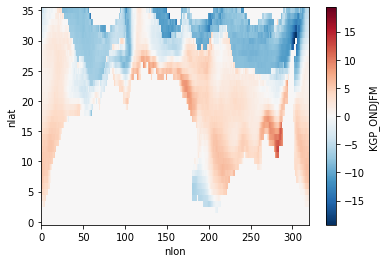

In [20]:
diff_abs.plot()

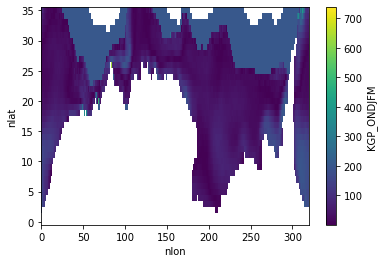

In [21]:
# mask some super high pct diffs
diff_pct.where(abs(diff_pct) <=1000).plot()

In [22]:
# mask the percent differences by where the difference is >10% (for stippling)
diff_pct_10 = mask_ones.where(abs(diff_pct) <= 10.0)

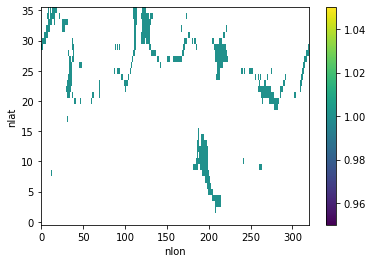

In [23]:
diff_pct_10.plot()

## Load the SST Data
 - Can choose March or all Summer

In [24]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/environment/'

In [25]:
# Read in cesm2-le  data
file_in = 'CESM2-LE-summer-mean-SST.nc'
ds_in = xr.open_mfdataset(dir_in+file_in,decode_times=False)

ds_in

<xarray.Dataset>
Dimensions:                        (time: 150, member_id: 50, nlat: 36, nlon: 320)
Coordinates:
  * time                           (time) int64 1950 1951 1952 ... 2098 2099
    SST_MAR                        (time, member_id, nlat, nlon) float64 dask.array<chunksize=(150, 50, 36, 320), meta=np.ndarray>
    TLONG                          (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TLAT                           (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
  * nlat                           (nlat) int64 0 1 2 3 4 5 ... 31 32 33 34 35
  * nlon                           (nlon) int64 0 1 2 3 4 ... 316 317 318 319
    TAREA                          (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    SST_ONDJFM                     (time, member_id, nlat, nlon) float64 dask.array<chunksize=(150, 50, 36, 320), meta=np.ndarray>
Dimensions without coordinates: member_id
Data variables:
    __xarray_dataarray_variable__  (time, member_id, nlat, nlon) float64 dask.array<chunksize=(150, 50, 36, 320), meta=np.ndarray>

In [26]:
# keep the variable of interest only
data = ds_in.SST_MAR

In [27]:
# reassign nlat and nlon for later
data['nlat'] = ds_grid.nlat
data['nlon'] = ds_grid.nlon

### Calculate SST decadal averages

In [28]:
# specify some arrays that will become coordinate arrays
decades = list(range(1960,2100,10))
decade_names = ['1960','1970','1980','1990','2000','2010','2020','2030','2040','2050','2060','2070','2080','2090']

In [29]:
# get dimensions of the grid we need to iterate over
xlen = len(ds_in.nlon)
ylen = len(ds_in.nlat)
dlen = len(decades)
print(xlen,ylen,dlen)

320 36 14


In [30]:
# Loop through decades

# make numpy array to fill and specify dimensions
array_decadal_all = np.zeros([dlen,ylen,xlen])

for dec in decades:
    print('Calculating decadal means for '+str(dec)+'s')
    # need to specify which spot in the array we'll fill for the decade
    if dec == 1960:
        count = 0
    else: 
        count = count+1    
    # set the start and end years for this decade
    yy_st = dec - 2
    yy_ed = dec +3
    yy = list(range(yy_st,yy_ed,1)) 
    # get data subset
    temp1 = data.where((data.time >= yy_st)&(data.time < yy_ed),drop=True)
    # calculate mean over time
    temp2 = temp1.mean(dim='time')
    # get ensemble mean
    array_decadal_all[count,:,:] = temp2.mean(dim='member_id')

# convert to xarray
sst_dec = xr.DataArray(array_decadal_all,dims=('decades','nlat','nlon'))
sst_dec['decades'] = decades
sst_dec['nlat'] = ds_grid.nlat
sst_dec['nlon'] = ds_grid.nlon

Calculating decadal means for 1960s
Calculating decadal means for 1970s
Calculating decadal means for 1980s
Calculating decadal means for 1990s
Calculating decadal means for 2000s
Calculating decadal means for 2010s
Calculating decadal means for 2020s
Calculating decadal means for 2030s
Calculating decadal means for 2040s
Calculating decadal means for 2050s
Calculating decadal means for 2060s
Calculating decadal means for 2070s
Calculating decadal means for 2080s
Calculating decadal means for 2090s


In [31]:
# save just two decades
sst_2000 = sst_dec.sel(decades=2000)
sst_2090 = sst_dec.sel(decades=2090)

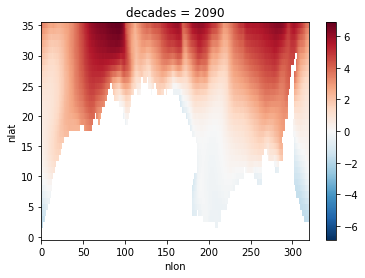

In [32]:
sst_2090.plot()

In [33]:
#create masks where the SST is less than 3C threshold for Krill
sst_mask_2000 = mask_ones.where(sst_2000 <=3.0)
sst_mask_2090 = mask_ones.where(sst_2090 <=3.0)

## Load regional mask data and shapefiles

In [34]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [35]:
# Read in CCAMLR planning domain masks
file_in = 'CCAMLR_masks/CESM_gx1v7_CCAMLR_masks_v8_10102024.nc'
ds_ccamlr= xr.open_mfdataset(dir_in+file_in,decode_times=False)
ds_ccamlr = ds_ccamlr.isel(nlat=slice(0,36))

# keep just masks of interest (MPA planning areas, polynya regions, coastal)
ccamlr_in = ['mpa_plan_1','mpa_plan_2', 'mpa_plan_3', 'mpa_plan_4', 'mpa_plan_5', 'mpa_plan_6', 'mpa_plan_7','mpa_plan_8','mpa_plan_9','mpa_plan_1_mod','mpa_plan_3_mod','mpa_plan_4_mod','mpa_plan_3_4','mpa_plan_7_mod']
ccamlr_masks = ds_ccamlr[ccamlr_in]

# now load in the different masks as a new coordinate
ccamlr_masks = xr.concat([ds_ccamlr.mpa_plan_1, ds_ccamlr.mpa_plan_2, ds_ccamlr.mpa_plan_3,
                          ds_ccamlr.mpa_plan_4, ds_ccamlr.mpa_plan_5, ds_ccamlr.mpa_plan_6,
                          ds_ccamlr.mpa_plan_7, ds_ccamlr.mpa_plan_8, ds_ccamlr.mpa_plan_9,
                          ds_ccamlr.mpa_plan_1_mod, ds_ccamlr.mpa_plan_3_mod, ds_ccamlr.mpa_plan_4_mod, 
                          ds_ccamlr.mpa_plan_3_4, ds_ccamlr.mpa_plan_7_mod],
                         dim='region')
ccamlr_masks['region']=ccamlr_in


In [36]:
# Read in Antarctic Geography Shapefiles
file_in = 'USNIC_ANTARC_shelf_2022/USNIC_ANTARC_shelf_2022.shp'

shdf_ant = gpd.read_file(dir_in+file_in)
# Important: convert the projection from the shapefile one to the cartopy one 
shdf_ant = shdf_ant.to_crs(ccrs.SouthPolarStereo())

## Plot figures

In [37]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [38]:
# get colony distance info for plotting
lons = ds_grid.TLONG
lats = ds_grid.TLAT

In [39]:
# make arrays for the Amundsen/Peninsula region
lats_bound = np.arange(-73, -50, 1)
#lats_bound
lons_bound = np.linspace(275, 275, lats_bound.shape[0])
#lons_bound

In [40]:
# mask to omit land points
data_mean_2000 = data_mean_2000.where(ds_grid.REGION_MASK == 1)
data_mean_2090 = data_mean_2090.where(ds_grid.REGION_MASK == 1)
diff_abs = diff_abs.where(ds_grid.REGION_MASK == 1)
diff_pct = diff_pct.where(ds_grid.REGION_MASK == 1)
diff_pct_10 = diff_pct_10.where(ds_grid.REGION_MASK == 1)

In [41]:
# mask outside of average decadal SIZ zone
data_mean_2000 = data_mean_2000.where(siz_2000 >0)
data_mean_2090 = data_mean_2090.where(siz_2090 >0)
diff_abs = diff_abs.where(siz_2090 >0)
diff_pct = diff_pct.where(siz_2090 >0)
diff_pct_10 = diff_pct_10.where(siz_2090 >0)

### Set plotting ranges, etc.

In [42]:
print('maximum value for 2000')
print(data_mean_2000.max(dim=['nlat','nlon']).values)
print('maximum value for 2090')
print(data_mean_2090.max(dim=['nlat','nlon']).values)

maximum value for 2000
27.235234062194824
maximum value for 2090
22.599040775299073


In [43]:
# set some plotting info
cmap_in = cmocean.cm.amp
vmin_in = 0.0
vmax_in = 25.0
levels_in_sst = np.arange(0,3,1)
levels_in_siz = np.arange(0,3,1)
levels_in_ctr = np.arange(0,3,1)

In [44]:
print('maximum and minimum absolute differences in growth 2090 - 2000')
print(diff_abs.max(dim=['nlat','nlon']).values)
print(diff_abs.min(dim=['nlat','nlon']).values)

maximum and minimum absolute differences in growth 2090 - 2000
13.171881278991698
-14.2375880180211


In [45]:
# set some plotting info
cmap_diff = cmocean.cm.balance
vmin_diff = -10.0
vmax_diff = 10.0
vmin_pct_diff = -250.0
vmax_pct_diff = 250.0

### Final Panel Plot

In [46]:
# set path for figure output
dir_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/ecoindex_figures/version_6/'
fout = 'Figure_6_KGP_siz_polynya_2000_2090'

#labels
lab1 = 'd) KGP 2000s'
lab2 = 'e) KGP 2090s'
lab3 = 'f) KGP Difference'
sz = 20

# legend line
lats_line = np.arange(-89.0, -85.0, 1)
lons_line = np.linspace(270,270,lats_line.shape[0])

In [47]:
units

'mm/year'

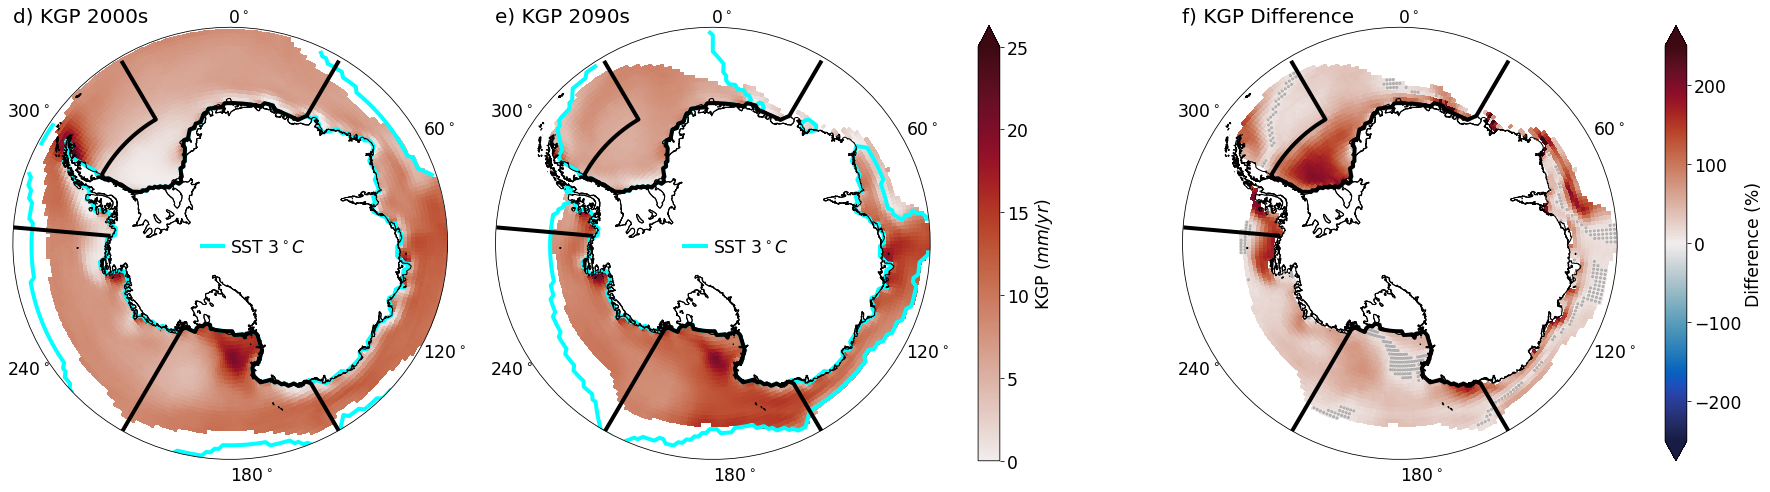

In [48]:
# Plot - percent difference (2090 - 2100)
# create figure
fig = plt.figure(figsize=(30,8))

# set plot spacing for the figure to include colorbars
gs = gridspec.GridSpec(nrows=1, ncols=6, width_ratios=(1, 1, 0.05, 0.2, 1, 0.05))

prj =ccrs.SouthPolarStereo()

# set all the different plot items
ax_map1 = plt.subplot(gs[0, 0], projection=prj)
ax_map2 = plt.subplot(gs[0, 1], projection=prj)
ax_map3 = plt.subplot(gs[0, 4], projection=prj)

ax_cb = plt.subplot(gs[0, 2])
ax_cb_diff = plt.subplot(gs[0, 5])

### Plot 1 - 2000 ###########################################################################
ax_map1.set_boundary(circle, transform=ax_map1.transAxes)
ax_map1.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
ax_map1.set_title(lab1,loc='left',fontsize=sz)
### Main Plot
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_mean_2000)
this=ax_map1.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
### Overlay SST
lon, lat, field = utils.adjust_pop_grid(lons,lats,sst_mask_2000.fillna(0))
this2=ax_map1.contour(lon,lat,field,
                 colors='cyan',linestyles='solid',linewidths=4,
                 levels=levels_in_sst,
                 transform=ccrs.PlateCarree())
# add SST legend
this2=ax_map1.plot(lons_line,lats_line, color='cyan',linestyle='solid',linewidth=4, transform=ccrs.PlateCarree())
this2=ax_map1.text(180.0,-89.0, r'SST $3 ^\circ C$', color='black', fontsize='xx-large', transform=ccrs.PlateCarree())
### Add Longitude Labels
# 0 Lon
ax_map1.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 60 Lon
ax_map1.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 120 Lon
ax_map1.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 180 Lon
ax_map1.text(180.0,-58.0, r'180$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 240 Lon
ax_map1.text(240,-55.0, r'240$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 300 Lon
ax_map1.text(300.0,-55.0, r'300$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax_map1.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax_map1.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax_map1.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree())
### Add shapefile coastlines
ax_map1.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

### Plot 2 - 2090 ###########################################################################
ax_map2.set_boundary(circle, transform=ax_map2.transAxes)
ax_map2.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
ax_map2.set_title(lab2,loc='left',fontsize=sz)
### Main Plot
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_mean_2090)
this=ax_map2.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
### Overlay SST
lon, lat, field = utils.adjust_pop_grid(lons,lats,sst_mask_2090.fillna(0))
this2=ax_map2.contour(lon,lat,field,
                 colors='cyan',linestyles='solid',linewidths=4,
                 levels=levels_in_sst,
                 transform=ccrs.PlateCarree()) 
# add SST legend
this2=ax_map2.plot(lons_line,lats_line, color='cyan',linestyle='solid',linewidth=4, transform=ccrs.PlateCarree())
this2=ax_map2.text(180.0,-89.0, r'SST $3 ^\circ C$', color='black', fontsize='xx-large', transform=ccrs.PlateCarree())
### Add Longitude Labels
# 0 Lon
ax_map2.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 60 Lon
ax_map2.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 120 Lon
ax_map2.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 180 Lon
ax_map2.text(180.0,-58.0, r'180$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 240 Lon
ax_map2.text(240,-55.0, r'240$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 300 Lon
ax_map2.text(300.0,-55.0, r'300$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax_map2.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax_map2.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax_map2.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree())
### Add shapefile coastlines
ax_map2.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

###################################### first color bar #################################
cbar1 = fig.colorbar(this, cax=ax_cb, extend='max')
cbar1.ax.tick_params(labelsize='xx-large')
cbar1.ax.set_ylabel(r'KGP ($mm/yr$)',fontsize='xx-large')

### Plot 3 - Difference ###########################################################################
ax_map3.set_boundary(circle, transform=ax_map3.transAxes)
ax_map3.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
ax_map3.set_title(lab3,loc='left',fontsize=sz)
### Main Plot
lon, lat, field = utils.adjust_pop_grid(lons,lats,diff_pct)
this=ax_map3.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_diff,                      
                     vmax=vmax_pct_diff, vmin=vmin_pct_diff,
                     transform=ccrs.PlateCarree())
### Overlay dots where values are < abs(10%) different 
lon, lat, field = utils.adjust_pop_grid(lons,lats,diff_pct_10)
this1 = ax_map3.scatter(lon, lat,
                   field,
                   color='darkgrey', marker='o', linewidths=2,
                   transform=ccrs.PlateCarree())
### Add Longitude Labels
# 0 Lon
ax_map3.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 60 Lon
ax_map3.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 120 Lon
ax_map3.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 180 Lon
ax_map3.text(180.0,-58.0, r'180$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 240 Lon
ax_map3.text(240,-55.0, r'240$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 300 Lon
ax_map3.text(300.0,-55.0, r'300$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax_map3.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax_map3.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax_map3.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree())
### Add shapefile coastlines
ax_map3.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

###################################### second color bar #################################
cbar2 = fig.colorbar(this, cax=ax_cb_diff, extend='both')
cbar2.ax.tick_params(labelsize='xx-large')
cbar2.ax.set_ylabel('Difference (%)',fontsize='xx-large')

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

### Individual Plots

In [ ]:
# Plot - 2000 mean
# create figure
fig = plt.figure(figsize=(10,10))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot info
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_mean_2000)
this=ax.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
cbar = ax.figure.colorbar(this,orientation='horizontal',extend='max',fraction=0.05,pad=0.01,shrink=0.8)
cbar.ax.tick_params(labelsize='xx-large')
cbar.ax.set_xlabel('Growing Season Total KGP ('+units+')',fontsize='xx-large')

### Overlay SST
lon, lat, field = utils.adjust_pop_grid(lons,lats,sst_mask_2000.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='cyan',linestyles='solid',linewidths=4,
                 levels=levels_in_sst,
                 transform=ccrs.PlateCarree()) 
### Overlay SIZ
lon, lat, field = utils.adjust_pop_grid(lons,lats,siz_2000.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_siz,
                 transform=ccrs.PlateCarree()) 
### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-59.5, r'180$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-58.0, r'240$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-58.0, r'300$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())

### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree())
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# Finalize figure and save
#fig.suptitle(title,fontsize=20, y=0.91)  
#fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
#fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

In [ ]:
# Plot - 2090 mean
# create figure
fig = plt.figure(figsize=(10,10))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot info
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_mean_2090)
this=ax.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
cbar = ax.figure.colorbar(this,orientation='horizontal',extend='max',fraction=0.05,pad=0.01,shrink=0.8)
cbar.ax.tick_params(labelsize='xx-large')
cbar.ax.set_xlabel('Growing Season Total KGP ('+units+')',fontsize='xx-large')

### Overlay SST
lon, lat, field = utils.adjust_pop_grid(lons,lats,sst_mask_2090.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='cyan',linestyles='solid',linewidths=4,
                 levels=levels_in_sst,
                 transform=ccrs.PlateCarree()) 
### Overlay SIZ
lon, lat, field = utils.adjust_pop_grid(lons,lats,siz_2090.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_siz,
                 transform=ccrs.PlateCarree()) 
### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-59.5, r'180$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-58.0, r'240$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-58.0, r'300$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())

### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree())
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# Finalize figure and save
#fig.suptitle(title,fontsize=20, y=0.91)  
#fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
#fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

In [ ]:
# Plot - absolute difference (2090 - 2100)
# create figure
fig = plt.figure(figsize=(10,10))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot info
lon, lat, field = utils.adjust_pop_grid(lons,lats,diff_abs)
this=ax.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_diff,                      
                     vmax=vmax_diff, vmin=vmin_diff,
                     transform=ccrs.PlateCarree())
cbar = ax.figure.colorbar(this,orientation='horizontal',extend='both',fraction=0.05,pad=0.01,shrink=0.8)
cbar.ax.tick_params(labelsize='xx-large')
cbar.ax.set_xlabel('Difference in Total KGP ('+units+')',fontsize='xx-large')

### Overlay SST
lon, lat, field = utils.adjust_pop_grid(lons,lats,sst_mask_2000.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='cyan',linestyles='dotted',linewidths=4,
                 levels=levels_in_sst,
                 transform=ccrs.PlateCarree()) 
lon, lat, field = utils.adjust_pop_grid(lons,lats,sst_mask_2090.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='cyan',linestyles='solid',linewidths=4,
                 levels=levels_in_sst,
                 transform=ccrs.PlateCarree()) 
### Overlay SIZ
lon, lat, field = utils.adjust_pop_grid(lons,lats,siz_2000.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='black',linestyles='dotted',linewidths=4,
                 levels=levels_in_siz,
                 transform=ccrs.PlateCarree()) 
lon, lat, field = utils.adjust_pop_grid(lons,lats,siz_2090.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_siz,
                 transform=ccrs.PlateCarree()) 
### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-59.5, r'180$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-58.0, r'240$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-58.0, r'300$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())

### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree())
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# Finalize figure and save
#fig.suptitle(title,fontsize=20, y=0.91)  
#fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
#fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

In [ ]:
# Plot - percent difference (2090 - 2100)
# create figure
fig = plt.figure(figsize=(10,10))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot info
lon, lat, field = utils.adjust_pop_grid(lons,lats,diff_pct)
this=ax.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_diff,                      
                     vmax=vmax_pct_diff, vmin=vmin_pct_diff,
                     transform=ccrs.PlateCarree())
cbar = ax.figure.colorbar(this,orientation='horizontal',extend='both',fraction=0.05,pad=0.01,shrink=0.8)
cbar.ax.tick_params(labelsize='xx-large')
cbar.ax.set_xlabel('Difference (%)',fontsize='xx-large')
### Overlay dots where values are < abs(10%) different 
lon, lat, field = utils.adjust_pop_grid(lons,lats,diff_pct_10)
this1 = ax.scatter(lon, lat,
                   field,
                   color='darkgrey', marker='o', linewidths=2,
                   transform=ccrs.PlateCarree())
### Overlay SST
lon, lat, field = utils.adjust_pop_grid(lons,lats,sst_mask_2000.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='cyan',linestyles='dotted',linewidths=4,
                 levels=levels_in_sst,
                 transform=ccrs.PlateCarree()) 
lon, lat, field = utils.adjust_pop_grid(lons,lats,sst_mask_2090.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='cyan',linestyles='solid',linewidths=4,
                 levels=levels_in_sst,
                 transform=ccrs.PlateCarree()) 
### Overlay SIZ
lon, lat, field = utils.adjust_pop_grid(lons,lats,siz_2000.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='black',linestyles='dotted',linewidths=4,
                 levels=levels_in_siz,
                 transform=ccrs.PlateCarree()) 
lon, lat, field = utils.adjust_pop_grid(lons,lats,siz_2090.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_siz,
                 transform=ccrs.PlateCarree()) 
### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-59.5, r'180$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-58.0, r'240$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-58.0, r'300$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())

### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree())
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# Finalize figure and save
#fig.suptitle(title,fontsize=20, y=0.91)  
#fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
#fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)